<a href="https://colab.research.google.com/github/drama-404/ml-projects-training/blob/main/Mechanism_of_Action_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import F1Score, Precision, Recall

from sklearn.model_selection import train_test_split

In [ ]:
train_x = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
train_y = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')

In [ ]:
train_x

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740


In [ ]:
features = train_x.columns
print('Features total:', len(features))
gene_expression_features = [feature for feature in features if feature.startswith('g-')]
print('Gene expression features:', len(gene_expression_features))
cell_viability_features = [feature for feature in features if feature.startswith('c-')]
print('Cell viability features:', len(cell_viability_features))
treatment_features = [feature for feature in features if feature.startswith('cp_')]
print('Treatment features:', len(treatment_features))

Features total: 876
Gene expression features: 772
Cell viability features: 100
Treatment features: 3


In [ ]:
drugs_data = pd.read_csv('/kaggle/input/lish-moa/train_drug.csv')
drugs_data

,sig_id,drug_id
0,id_000644bb2,b68db1d53
1,id_000779bfc,df89a8e5a
2,id_000a6266a,18bb41b2c
3,id_0015fd391,8c7f86626
4,id_001626bd3,7cbed3131
...,...,...
23809,id_fffb1ceed,df1d0a5a1
23810,id_fffb70c0c,ecf3b6b74
23811,id_fffc1c3f4,cacb2b860
23812,id_fffcb9e7c,8b87a7a83


In [ ]:
drugs_data.drug_id.nunique()

3289

In [ ]:
# Top freq compound:
drugs_data.drug_id.value_counts()[:1]

cacb2b860    1866
Name: drug_id, dtype: int64

In [ ]:
#MoA's of 1 compound are identical
cacb2b860_idx = drugs_data['drug_id'][drugs_data['drug_id']== 'cacb2b860'].index
cacb2b860_rows = train_y.iloc[cacb2b860_idx].copy().drop('sig_id', axis=1)
cacb2b860_rows.drop_duplicates()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


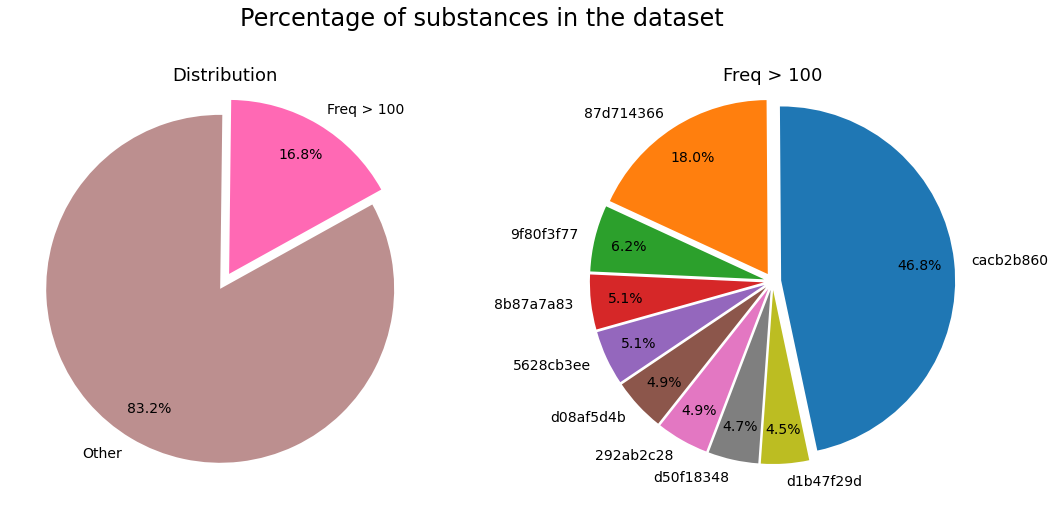

In [ ]:
drugs_freq = drugs_data['drug_id'].value_counts()
drugs_freq_top = drugs_freq[drugs_freq >= 100]
drugs_freq_bin = pd.Series(dtype='float')
drugs_freq_bin['Freq > 100'] = drugs_freq_top.sum()
drugs_freq_bin['Other'] = drugs_freq[drugs_freq < 100].sum()

fig, axes = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = axes 
fig.set_figheight(8)
fig.set_figwidth(18)

ax1.set_title('Distribution', fontsize=18, y=0.95)

ax1.pie(
    drugs_freq_bin,
    colors=['hotpink', 'rosybrown'],
    labels=drugs_freq_bin.index,
    textprops={'fontsize':14},
    startangle=29,
    explode=[0.05, 0.05],
    autopct='%1.1f%%',
    pctdistance=0.8,
    labeldistance=1.1,
)

ax2.set_title('Freq > 100', fontsize=18, y=0.95)

ax2.pie(
    drugs_freq_top,
    labels=drugs_freq_top.index,
    textprops={'fontsize':14},
    startangle=-78,
    explode=[0.05] * len(drugs_freq_top + 1),
    autopct='%1.1f%%',
    pctdistance=0.8,
    labeldistance=1.1,
)

fig.suptitle("Percentage of substances in the dataset", fontsize=24)

for ax in axes:
    ax.axis('off') 

plt.show()

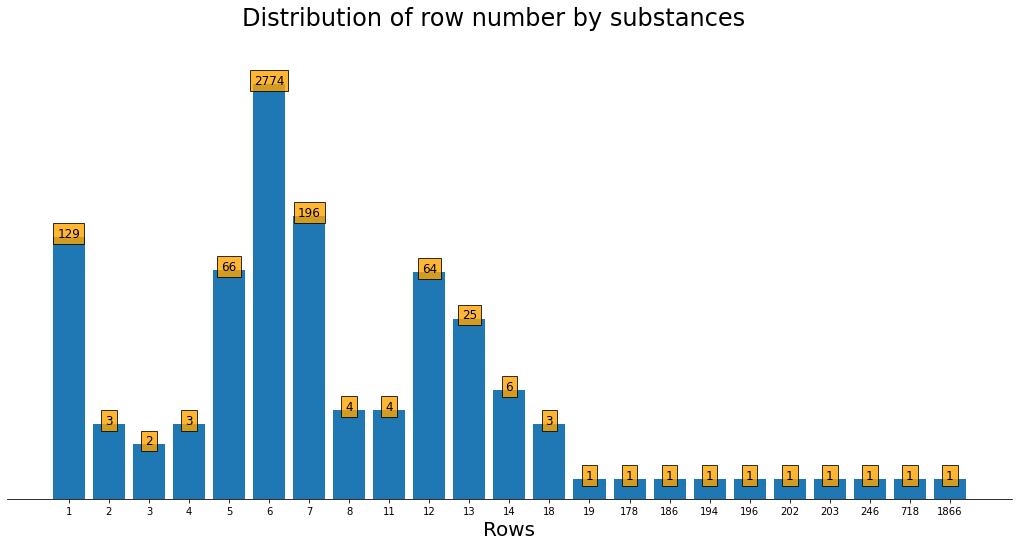

In [ ]:
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(18)
ax = plt.gca()

freq_counts = drugs_freq.value_counts().sort_index()
x = freq_counts.index
y = freq_counts.values
default_x_ticks = range(len(x))
ax.bar(default_x_ticks, y, log=True)
ax.get_yaxis().set_visible(False)
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
plt.xticks(default_x_ticks, x)
fig.suptitle("Distribution of row number by substances", fontsize=24)

for i in range(len(default_x_ticks)):
    plt.text(i, y[i], y[i], ha = 'center', fontsize=12, bbox = dict(facecolor = 'orange', alpha=0.8))
plt.xlabel('Rows', fontsize=20)

plt.show()

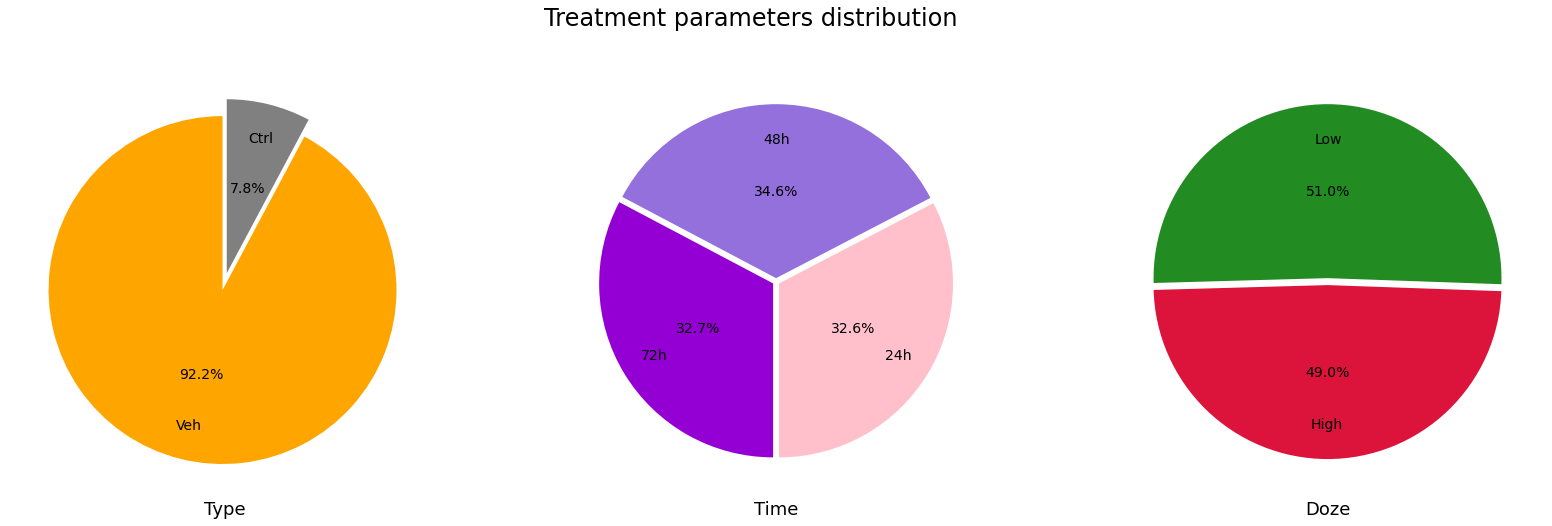

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
ax1, ax2, ax3 = axes 
fig.set_figheight(8)
fig.set_figwidth(28)

ax1.set_title('Type', fontsize=18, y=-0.05)
cp_type_data = (train_x['cp_type'].value_counts() * 100 / len(train_x)).round(1)
pie_items = ax1.pie(
    cp_type_data,
    colors=['orange', 'gray'],
    labels=['Veh', 'Ctrl'],
    textprops={'fontsize':14},
    startangle=90,
    explode=[0.05, 0.05],
    autopct='%1.1f%%',
    pctdistance=0.5,
    labeldistance=0.8,
)
for text in pie_items[1]:
    text.set_horizontalalignment('center')

ax2.set_title('Time', fontsize=18, y=-0.05)

cp_time_data = (
    train_x['cp_time'].value_counts().sort_index() * 100 / len(train_x)
).round(1)
pie_items = ax2.pie(
    cp_time_data,
    colors=['pink','mediumpurple','darkviolet'],
    labels=['24h', '48h', '72h'],
    textprops={'fontsize':14},
    startangle=-90,
    explode=[0.02, 0.02, 0.02],
    autopct='%1.1f%%',
    pctdistance=0.5,
    labeldistance=0.8,
)
for text in pie_items[1]:
    text.set_horizontalalignment('center')

ax3.set_title('Doze', fontsize=18, y=-0.05)
#ax3.get_yaxis().set_ticks([20, 40])
cp_dose_data = (train_x['cp_dose'].value_counts() * 100 / len(train_x)).round(1)
pie_items = ax3.pie(
    cp_dose_data,
    colors=['forestgreen', 'crimson'],
    labels=['Low', 'High'],
    textprops={'fontsize':14},
    startangle=-2,
    explode=[0.02, 0.02],
    autopct='%1.1f%%',
    pctdistance=0.5,
    labeldistance=0.8,
)
for text in pie_items[1]:
    text.set_horizontalalignment('center')


fig.suptitle("Treatment parameters distribution", fontsize=24)

for ax in axes:
    ax.axis('off') 

plt.show()

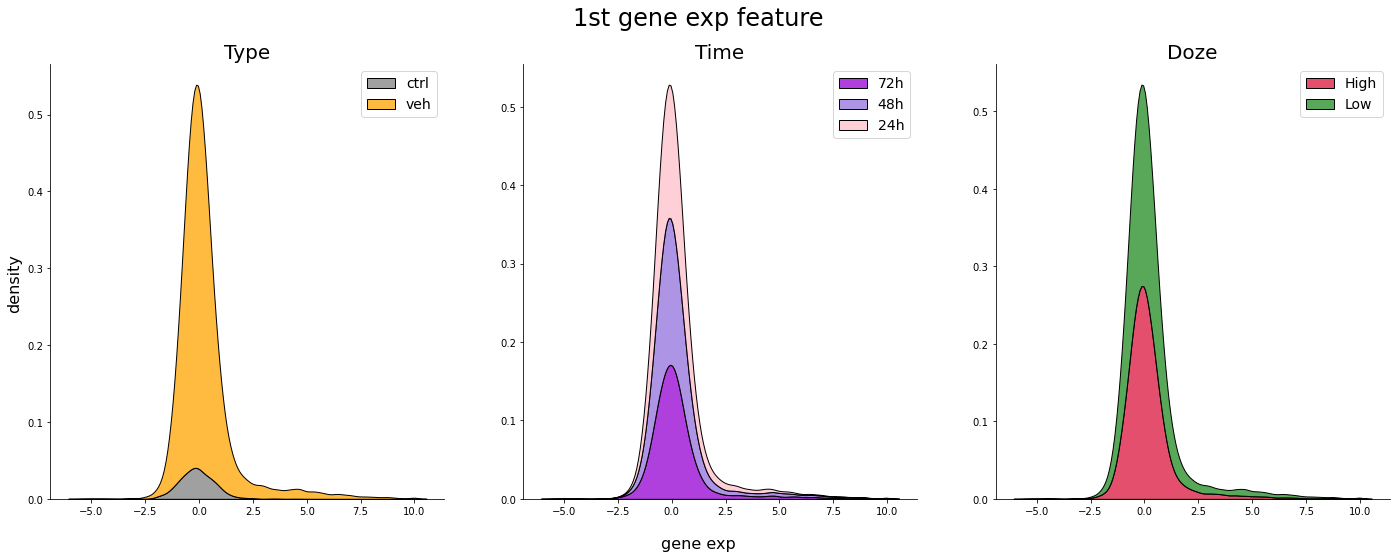

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(24)

subplot1 = sns.kdeplot(
    ax=axes[0],
    data=train_x,
    x='g-0',
    hue='cp_type',
    palette=['orange', 'gray'],
    multiple='stack'
)
subplot1.legend(['ctrl', 'veh'], loc=1, prop={'size': 14})
subplot1.set_title('Type', fontsize=20)

subplot2 = sns.kdeplot(
    ax=axes[1],
    data=train_x,
    x='g-0',
    hue='cp_time',
    palette=['pink','mediumpurple','darkviolet'],
    multiple='stack'
)
subplot2.legend(['72h','48h', '24h'], loc=1, prop={'size': 14})
subplot2.set_title('Time', fontsize=20)

subplot3 = sns.kdeplot(
    ax=axes[2],
    data=train_x,
    x='g-0',
    hue='cp_dose',
    palette=['forestgreen', 'crimson'],
    multiple='stack'
)
subplot3.legend(['High', 'Low'], loc=1, prop={'size': 14})
subplot3.set_title('Doze', fontsize=20)

for subplot in (subplot1, subplot2, subplot3):
    subplot.set_ylabel('')
    subplot.set_xlabel('')
for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

fig.text(0.5, 0.04, 'gene exp', ha='center', fontsize=16)
fig.text(0.1, 0.5, 'density', va='center', rotation='vertical', fontsize=16)

fig.suptitle("1st gene exp feature", fontsize=24)
plt.show()

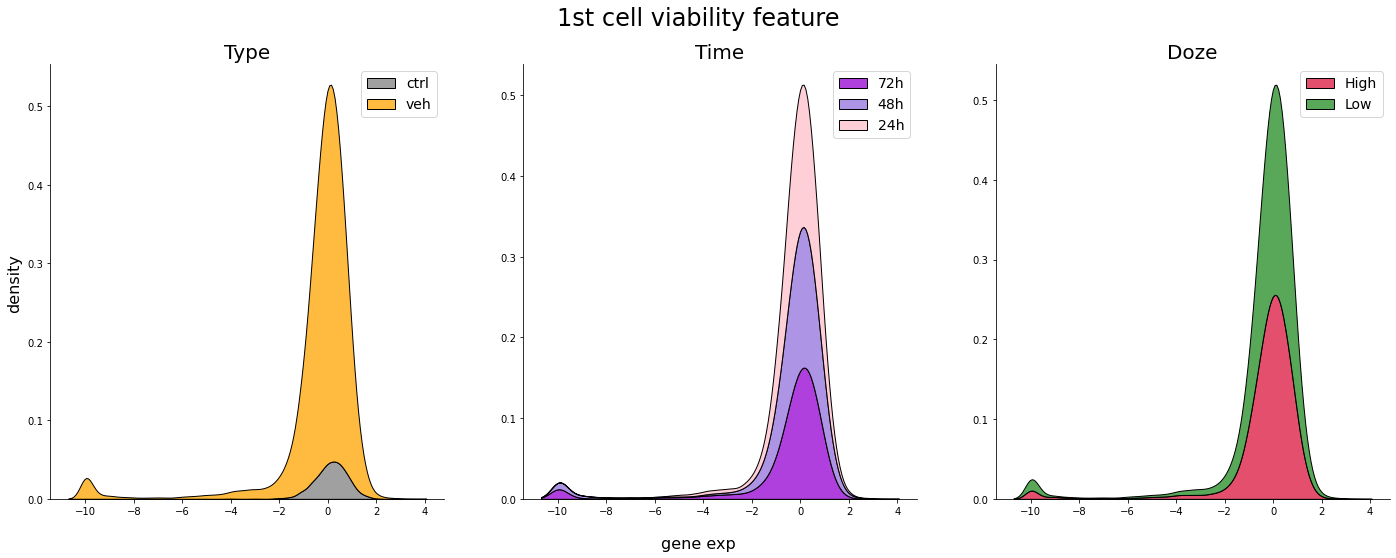

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(24)

subplot1 = sns.kdeplot(
    ax=axes[0],
    data=train_x,
    x='c-0',
    hue='cp_type',
    palette=['orange', 'gray'],
    multiple='stack'
)
subplot1.legend(['ctrl', 'veh'], loc=1, prop={'size': 14})
subplot1.set_title('Type', fontsize=20)

subplot2 = sns.kdeplot(
    ax=axes[1],
    data=train_x,
    x='c-0',
    hue='cp_time',
    palette=['pink','mediumpurple','darkviolet'],
    multiple='stack'
)
subplot2.legend(['72h','48h', '24h'], loc=1, prop={'size': 14})
subplot2.set_title('Time', fontsize=20)

subplot3 = sns.kdeplot(
    ax=axes[2],
    data=train_x,
    x='c-0',
    hue='cp_dose',
    palette=['forestgreen', 'crimson'],
    multiple='stack'
)
subplot3.legend(['High', 'Low'], loc=1, prop={'size': 14})
subplot3.set_title('Doze', fontsize=20)

for subplot in (subplot1, subplot2, subplot3):
    subplot.set_ylabel('')
    subplot.set_xlabel('')
for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

fig.text(0.5, 0.04, 'gene exp', ha='center', fontsize=16)
fig.text(0.1, 0.5, 'density', va='center', rotation='vertical', fontsize=16)

fig.suptitle("1st cell viability feature", fontsize=24)
plt.show()

In [ ]:
train_x['g_total'] = train_x[gene_expression_features].sum(axis=1)
train_x['c_total'] = train_x[cell_viability_features].sum(axis=1)

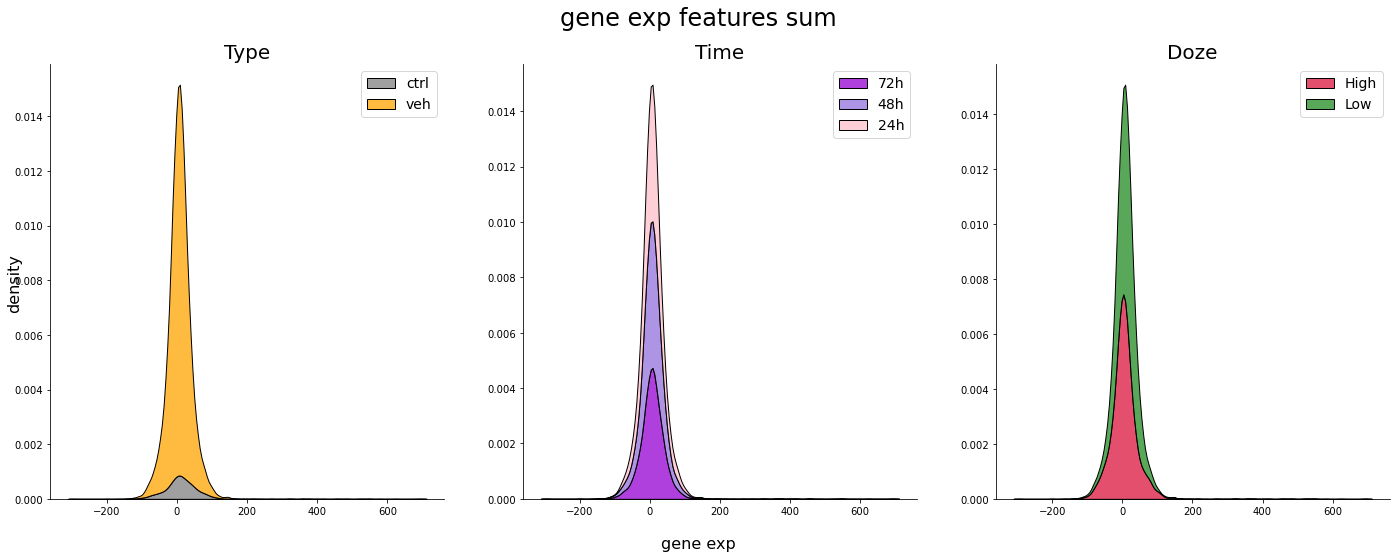

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(24)

subplot1 = sns.kdeplot(
    ax=axes[0],
    data=train_x,
    x='g_total',
    hue='cp_type',
    palette=['orange', 'gray'],
    multiple='stack'
)
subplot1.legend(['ctrl', 'veh'], loc=1, prop={'size': 14})
subplot1.set_title('Type', fontsize=20)

subplot2 = sns.kdeplot(
    ax=axes[1],
    data=train_x,
    x='g_total',
    hue='cp_time',
    palette=['pink','mediumpurple','darkviolet'],
    multiple='stack'
)
subplot2.legend(['72h','48h', '24h'], loc=1, prop={'size': 14})
subplot2.set_title('Time', fontsize=20)

subplot3 = sns.kdeplot(
    ax=axes[2],
    data=train_x,
    x='g_total',
    hue='cp_dose',
    palette=['forestgreen', 'crimson'],
    multiple='stack'
)
subplot3.legend(['High', 'Low'], loc=1, prop={'size': 14})
subplot3.set_title('Doze', fontsize=20)

for subplot in (subplot1, subplot2, subplot3):
    subplot.set_ylabel('')
    subplot.set_xlabel('')
for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

fig.text(0.5, 0.04, 'gene exp', ha='center', fontsize=16)
fig.text(0.1, 0.5, 'density', va='center', rotation='vertical', fontsize=16)

fig.suptitle("gene exp features sum", fontsize=24)
plt.show()

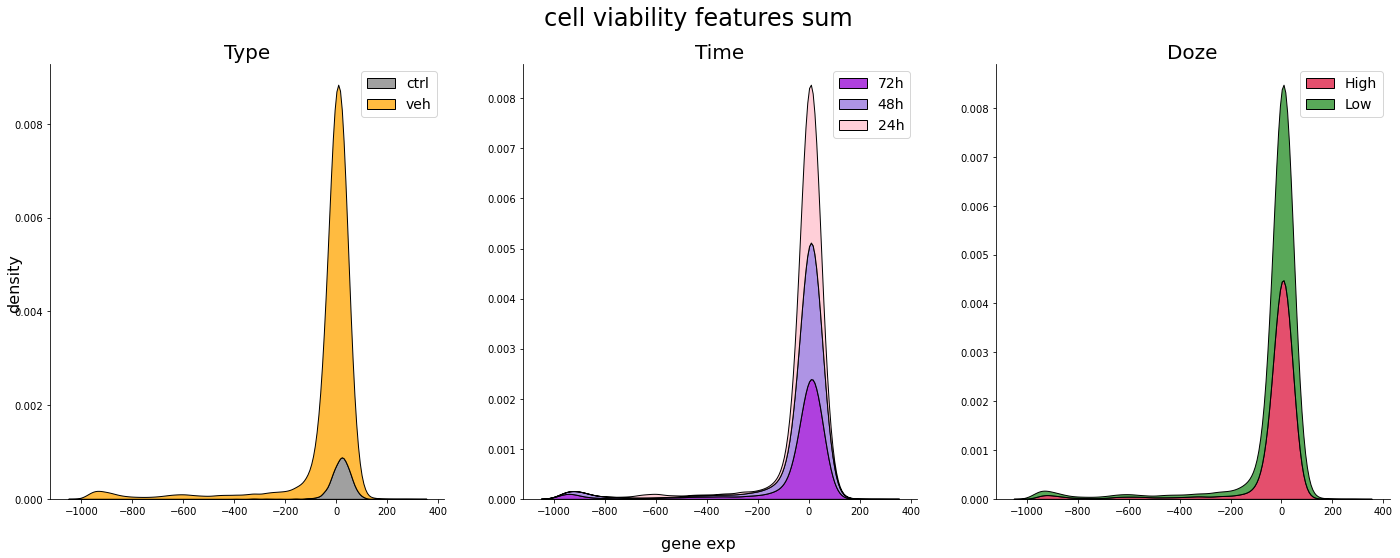

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(8)
fig.set_figwidth(24)

subplot1 = sns.kdeplot(
    ax=axes[0],
    data=train_x,
    x='c_total',
    hue='cp_type',
    palette=['orange', 'gray'],
    multiple='stack'
)
subplot1.legend(['ctrl', 'veh'], loc=1, prop={'size': 14})
subplot1.set_title('Type', fontsize=20)

subplot2 = sns.kdeplot(
    ax=axes[1],
    data=train_x,
    x='c_total',
    hue='cp_time',
    palette=['pink','mediumpurple','darkviolet'],
    multiple='stack'
)
subplot2.legend(['72h','48h', '24h'], loc=1, prop={'size': 14})
subplot2.set_title('Time', fontsize=20)

subplot3 = sns.kdeplot(
    ax=axes[2],
    data=train_x,
    x='c_total',
    hue='cp_dose',
    palette=['forestgreen', 'crimson'],
    multiple='stack'
)
subplot3.legend(['High', 'Low'], loc=1, prop={'size': 14})
subplot3.set_title('Doze', fontsize=20)

for subplot in (subplot1, subplot2, subplot3):
    subplot.set_ylabel('')
    subplot.set_xlabel('')
for ax in axes:
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

fig.text(0.5, 0.04, 'gene exp', ha='center', fontsize=16)
fig.text(0.1, 0.5, 'density', va='center', rotation='vertical', fontsize=16)

fig.suptitle("cell viability features sum", fontsize=24)
plt.show()

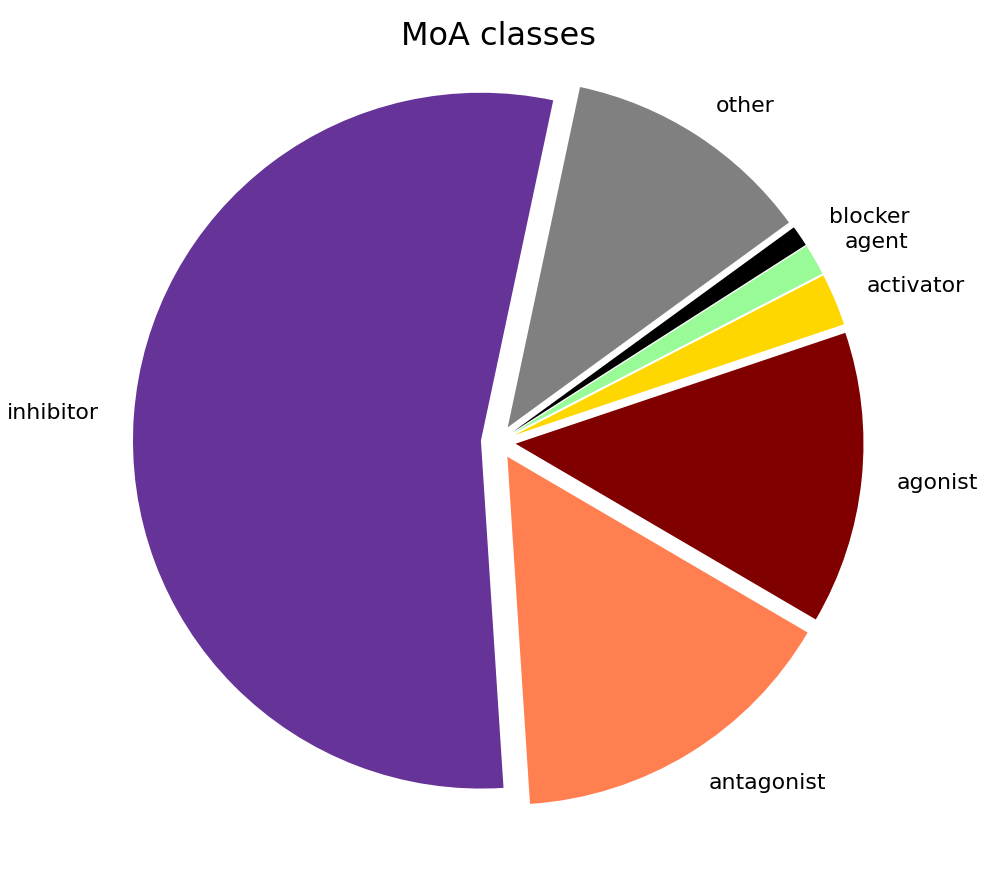

In [ ]:
moa_types_dict = {}
for col in train_y.columns[1:]:
    moa_type = col.rsplit('_', 1)[-1]
    if moa_type in moa_types_dict:
        moa_types_dict[moa_type] += 1
    else:
        moa_types_dict[moa_type] = 1

moa_types = pd.Series({k: v for k, v in sorted(moa_types_dict.items(), key=lambda item: item[1])})

oth =  moa_types[:-6].sum()
moa_types = moa_types[-6:][::-1]
moa_types['other'] = oth

fig, axes = plt.subplots(nrows=1, ncols=1)
ax1 = axes 
fig.set_figheight(16)
fig.set_figwidth(18)

ax1.set_title('MoA classes', fontsize=32, y=0.95)

pie_items = ax1.pie(
    moa_types,
    colors=['rebeccapurple', 'coral', 'maroon', 'gold', 'palegreen', 'black', 'grey'],
    labels=list(moa_types.index),
    textprops={'fontsize':22},
    startangle=78,
    explode=[0.05]*len(moa_types.index),
    labeldistance=1.1,
)


ax1.axis('off') 

plt.show()

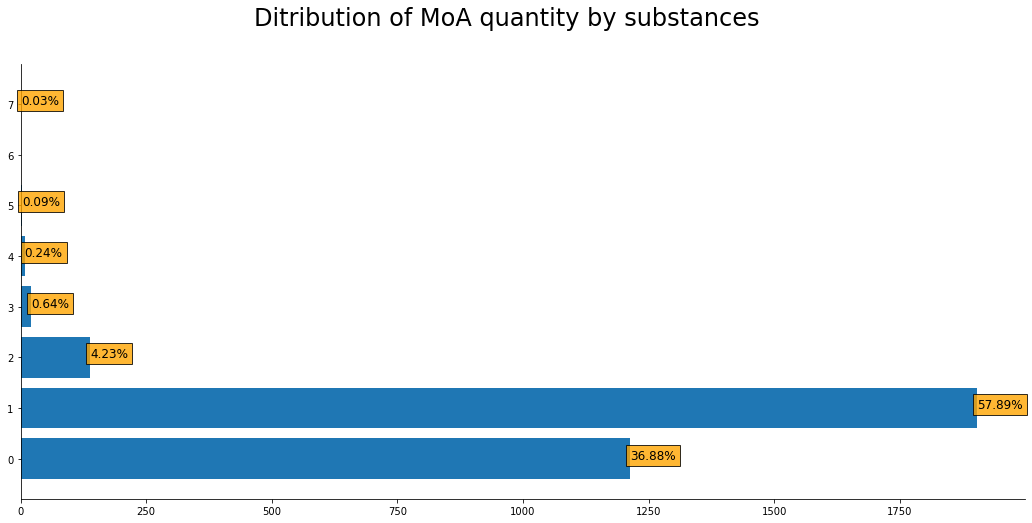

In [ ]:
drugs_set_idx = drugs_data.drop_duplicates(subset=['drug_id']).index
train_y_set = train_y.iloc[drugs_set_idx].drop('sig_id', axis=1)
train_y_set['total_activations'] = train_y_set.sum(axis=1)
activations_data = train_y_set['total_activations'].value_counts().sort_index()

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(18)
ax = plt.gca()
x = list(activations_data.index)
y = activations_data.values
ax.barh(x, y, color=['tab:blue'])

for i in range(x[-1]+1):
    try:
        y_i = y[x.index(i)]
    except:
        continue
    y_percent = '%.2f' % (y_i / train_y_set['total_activations'].count() * 100) + '%'
    plt.text(y_i, i,  y_percent, ha = 'left', fontsize=12, bbox = dict(facecolor = 'orange', alpha=0.8))
    
fig.suptitle("Ditribution of MoA quantity by substances", fontsize=24)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

plt.show()

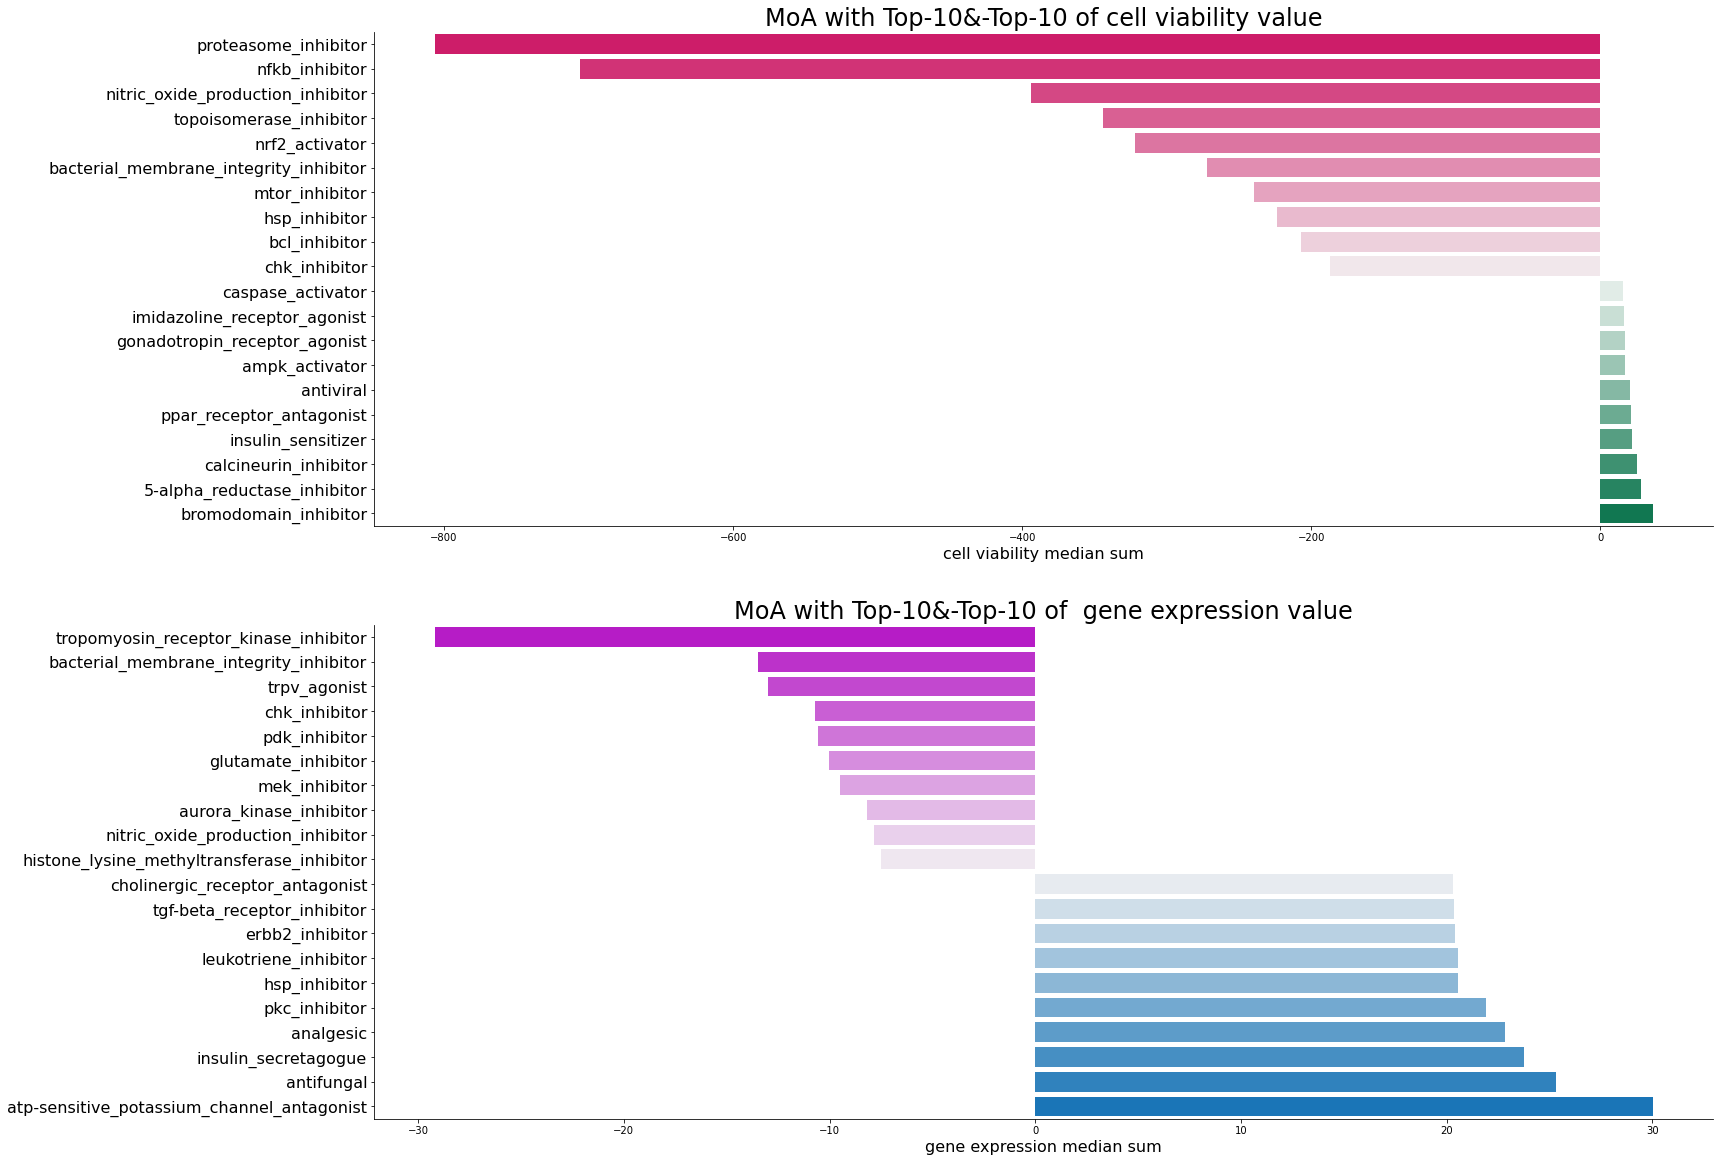

In [ ]:
moa_viability_dict = {}
for col in train_y.columns[1:]:
    moa_viability_dict[col] = train_x.iloc[train_y[train_y[col] == 1].index].c_total.mean()

moa_viability = pd.Series({k: v for k, v in sorted(moa_viability_dict.items(), key=lambda item: item[1])})

moa_gene_exp_dict = {}
for col in train_y.columns[1:]:
    moa_gene_exp_dict[col] = train_x.iloc[train_y[train_y[col] == 1].index].g_total.mean()

moa_gene_exp = pd.Series({k: v for k, v in sorted(moa_gene_exp_dict.items(), key=lambda item: item[1])})

fig, axes = plt.subplots(nrows=2, ncols=1)  

fig.set_figheight(20)
fig.set_figwidth(24)

subset_idx = list(moa_viability.index)
subset_idx = subset_idx[:10] + subset_idx[-10:]
subset = list(moa_viability)
subset = subset[:10] + subset[-10:]
palette = sns.diverging_palette(0, 145, s=100, n = len(subset))
subplot1 = sns.barplot(x=subset, y=subset_idx, ax=axes[0], palette=palette)

subplot1.set_xlabel('cell viability median sum', fontsize=16)
subplot1.set_title("MoA with Top-10&-Top-10 of cell viability value", fontsize=24)

subset_idx = list(moa_gene_exp.index)
subset_idx = subset_idx[:10] + subset_idx[-10:]
subset = list(moa_gene_exp)
subset = subset[:10] + subset[-10:]
palette = reversed(sns.diverging_palette(250, 300, s=100, n = len(subset)))
subplot2 = sns.barplot(x=subset, y=subset_idx, ax=axes[1], palette=palette)

subplot2.set_title("MoA with Top-10&-Top-10 of  gene expression value", fontsize=24)
subplot2.set_xlabel('gene expression median sum', fontsize=16)

for ax in axes:
    for spine in ['top', 'right']:
        ax.tick_params(axis='y', labelsize=16)
        ax.spines[spine].set_visible(False)

plt.show()

In [ ]:
def prepare_data(data):
    data.drop('sig_id', axis=1, inplace=True)
    
    data.loc[data.cp_type == 'trt_cp', 'cp_type'] = 1
    data.loc[data.cp_type == 'ctl_vehicle', 'cp_type'] = 0
    
    data.loc[data.cp_time == 24, 'cp_time'] = 0.33
    data.loc[data.cp_time == 48, 'cp_time'] = 0.66
    data.loc[data.cp_time == 72, 'cp_time'] = 0.99
    
    data.loc[data.cp_dose == 'D1', 'cp_dose'] = 0.5
    data.loc[data.cp_dose == 'D2', 'cp_dose'] = 1
    return data
    
train_x = prepare_data(pd.read_csv('/kaggle/input/lish-moa/train_features.csv'))
train_y = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv').drop('sig_id', axis=1)
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, random_state=42)


X_train = torch.tensor(X_train.to_numpy().astype('float32'))
X_val = torch.tensor(X_val.to_numpy().astype('float32'))
y_train = torch.tensor(y_train.to_numpy().astype('float32'))
y_val = torch.tensor(y_val.to_numpy().astype('float32'))

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

f1_metrics = F1Score(task="multilabel", num_labels=y_train.shape[1]).to(device)
precision_metrics = Precision(task="multilabel", num_labels=y_train.shape[1]).to(device)
recall_metrics = Recall(task="multilabel", num_labels=y_train.shape[1]).to(device)

def calc_metrics(y_pred, y_batch):
    f1 = f1_metrics(y_pred, y_batch).cpu().numpy().mean()
    precision = precision_metrics(y_pred, y_batch).cpu().numpy().mean()
    recall = recall_metrics(y_pred, y_batch).cpu().numpy().mean()
    return f1, precision, recall

def iterate_minibatches(X, y, batch_size, device):
    indices = np.random.permutation(np.arange(len(X)))
    for start in range(0, len(indices), batch_size):
        ix = indices[start: start + batch_size]
        x_i = torch.as_tensor(X[ix], dtype=torch.float).to(device)
        y_i = torch.as_tensor(y[ix], dtype=torch.float).to(device)
        yield x_i, y_i

def train_loop(
    model,
    opt,
    criterion,
    device,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=256,
    n_epochs=10
):  
    
    train_loss = []
    train_f1 = []
    train_precision = []
    train_recall = []

    val_loss = []
    val_f1 = []
    val_precision = []
    val_recall = []
        
    for epoch in range(1, n_epochs):
        print(f"{'-' * 12}\nEpoch {epoch}/{n_epochs}")
        current_epoch_train_loss = []

        current_epoch_train_f1 = []
        current_epoch_train_precision = []
        current_epoch_train_recall = []

        model.train(True)
        for X_batch, y_batch in iterate_minibatches(X_train, y_train, batch_size, device):
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            current_epoch_train_loss.append(loss.item())
            y_pred_logits = (y_pred > 0.5).float()

            f1, precision, recall = calc_metrics(y_pred_logits, y_batch)

            current_epoch_train_f1.append(f1)
            current_epoch_train_precision.append(precision)
            current_epoch_train_recall.append(recall)
        
        train_loss.append(np.array(current_epoch_train_loss).mean())
        
        train_f1.append(np.array(current_epoch_train_f1).mean())
        train_precision.append(np.array(current_epoch_train_precision).mean())
        train_recall.append(np.array(current_epoch_train_recall).mean())
        print(f"Train      Loss {'%.3f' % train_loss[-1]}. Metrics: ", end='')
        print(f"f1 {'%.3f' % train_f1[-1]}|precision {'%.3f' % train_precision[-1]}|recall {'%.3f' % train_recall[-1]}")
        
        model.train(False)
        current_epoch_val_loss = []
        current_epoch_val_f1 = []
        current_epoch_val_precision = []
        current_epoch_val_recall = []

        for X_batch, y_batch in iterate_minibatches(X_val, y_val, batch_size, device):
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            current_epoch_val_loss.append(loss.item())
            y_pred_logits = (y_pred > 0.5).float()

            f1, precision, recall = calc_metrics(y_pred_logits, y_batch)

            current_epoch_val_f1.append(f1)
            current_epoch_val_precision.append(precision)
            current_epoch_val_recall.append(recall)

        val_loss.append(np.array(current_epoch_val_loss).mean())

        val_f1.append(np.array(current_epoch_val_f1).mean())
        val_precision.append(np.array(current_epoch_val_precision).mean())
        val_recall.append(np.array(current_epoch_val_recall).mean())

        print(f"Validation Loss {'%.3f' % val_loss[-1]}. Metrics: ", end='')
        print(f"f1 {'%.3f' % val_f1[-1]}|precision {'%.3f' % val_precision[-1]}|recall {'%.3f' % val_recall[-1]}")
        
    
    train_history = {
        'loss': {'train': train_loss, 'val': val_loss},
        'f1': {'train': train_f1, 'val': val_f1},
        'precision': {'train': train_precision, 'val': val_precision},
        'recall': {'train': train_recall, 'val': val_recall},
    }
    
    return train_history

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        tp = torch.sum(inputs * targets)  
        total = torch.sum(inputs + targets)
        dice_loss = 1 - (2 * tp + smooth)/(total + smooth)  
        
        return dice_loss      

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        tp = torch.sum(inputs * targets)  
        total = torch.sum(inputs + targets)
        dice_loss = 1 - (2 * tp + smooth)/(total + smooth) 
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='mean')
        
        return bce_loss + dice_loss   
    
    
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        intersection = torch.sum(inputs * targets)  
        total = torch.sum(inputs + targets)
        union = total - intersection
        
        iou_loss = (intersection + smooth) / (union + smooth)
        
        return 1 - iou_loss
    
    
class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=0.5, beta=0.5):
        
        tp = torch.sum(inputs * targets)
        fp = torch.sum((1 - targets) * inputs)
        fn = torch.sum(targets * (1 - inputs))
        
        tversky_loss = (tp + smooth) / (tp + fp*alpha + fn*beta + smooth)
        
        return 1 - tversky_loss


In [ ]:
input_channels_num = train_x.shape[-1]
output_channels_num = train_y.shape[-1]

gene_expression_features_num = 772
cell_viability_features_num = 100
main_features_num = 3
  
    
class OutputBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.output_block = nn.Sequential(
            nn.BatchNorm1d(584),
            nn.Dropout(0.5),
            nn.Linear(584, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(256, output_channels_num),
            nn.Sigmoid()
        )

    def forward(self, x0, x1, x2):
        x = torch.cat([x0, x1, x2], dim=1)
        return self.output_block(x)    
    
class Model_v3(nn.Module):
    def __init__(self):
        super(Model_v3, self).__init__()
        
        self.main_features_input_layer = nn.Linear(main_features_num, 8)
                
        self.gene_expression_block = nn.Sequential(
            nn.BatchNorm1d(gene_expression_features_num),
            nn.ReLU(),
            nn.Linear(gene_expression_features_num, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.5),
            nn.Unflatten(1, (32, 32)),
            nn.Conv1d(32, 64, kernel_size = 3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Conv1d(64, 128, kernel_size = 3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Conv1d(128, 256, kernel_size = 3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.BatchNorm1d(256),
            nn.Flatten(),
            nn.Linear(1024, 512),
        )
        
        self.cell_viability_block = nn.Sequential(
            nn.BatchNorm1d(cell_viability_features_num),
            nn.ReLU(),
            nn.Linear(cell_viability_features_num, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Unflatten(1, (16, 16)),
            nn.Conv1d(16, 32, kernel_size = 3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.BatchNorm1d(32),
            nn.Dropout(0.5),
            nn.Conv1d(32, 64, kernel_size = 3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),
            nn.Conv1d(64, 128, kernel_size = 3, padding=1),
            nn.MaxPool1d(2),
            nn.ReLU(),
            
            nn.BatchNorm1d(128),
            nn.Flatten(),
            nn.Linear(256, 64),
        )
        
        self.output_block = OutputBlock()
        
    def forward(self, x):
        x0 = self.main_features_input_layer(x[:,:3])
        x1 = self.gene_expression_block(x[:,3:-100])
        x2 = self.cell_viability_block(x[:,-100:])
        
        return self.output_block(x0, x1, x2)


In [ ]:
model = Model_v3().to(device)
opt = torch.optim.Adam(model.parameters())

train_history_m3 = train_loop(
    model,
    torch.optim.Adam(model.parameters()),
    DiceBCELoss(),
    device,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=4096,
    n_epochs=200
)

------------
Epoch 1/200
Train      Loss 1.623. Metrics: f1 0.008|precision 0.004|recall 0.372
Validation Loss 1.381. Metrics: f1 0.014|precision 0.008|recall 0.096
------------
Epoch 2/200
Train      Loss 1.308. Metrics: f1 0.012|precision 0.006|recall 0.129
Validation Loss 1.060. Metrics: f1 0.024|precision 0.016|recall 0.045
------------
Epoch 3/200
Train      Loss 1.088. Metrics: f1 0.023|precision 0.013|recall 0.086
Validation Loss 1.011. Metrics: f1 0.075|precision 0.073|recall 0.078
------------
Epoch 4/200
Train      Loss 1.021. Metrics: f1 0.052|precision 0.038|recall 0.088
Validation Loss 1.093. Metrics: f1 0.117|precision 0.219|recall 0.080
------------
Epoch 5/200
Train      Loss 0.974. Metrics: f1 0.096|precision 0.106|recall 0.090
Validation Loss 1.026. Metrics: f1 0.118|precision 0.234|recall 0.079
------------
Epoch 6/200
Train      Loss 0.935. Metrics: f1 0.123|precision 0.194|recall 0.090
Validation Loss 0.956. Metrics: f1 0.121|precision 0.254|recall 0.080
----------

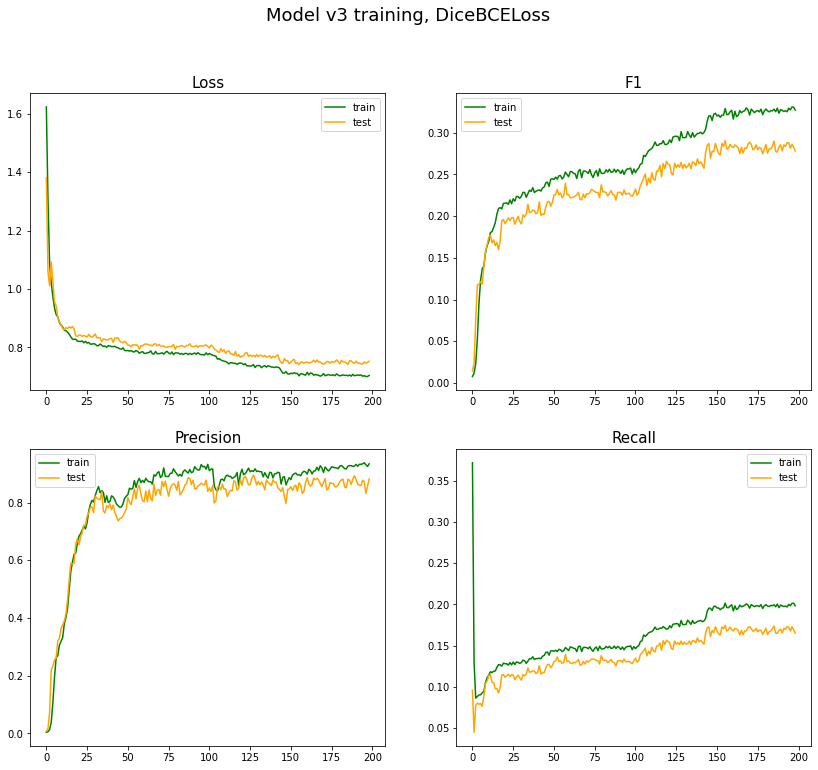

In [ ]:
history = train_history_m3

nrows=2
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=nrows)  
fig.set_figheight(12)
fig.set_figwidth(14)

for ax, data_part in zip(axes.flatten(), history):
    ax.plot(history[data_part]['train'], label='train', color='green')
    ax.plot(history[data_part]['val'], label='test', color='orange')
    ax.set_title(data_part.capitalize(), fontsize=15)
    ax.legend()

fig.suptitle("Model v3 training, DiceBCELoss", fontsize=18)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
test_x = prepare_data(pd.read_csv('/kaggle/input/lish-moa/test_features.csv'))
preds = model(torch.tensor(test_x.to_numpy().astype('float32')).to(device))
preds = (preds > 0.5).float()

sub = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
sub.iloc[:,1:] = preds.detach().cpu().numpy()

sub.to_csv('submission.csv', index=False)